# Model building and testing

We shall begin with a linear model baseline, then move to gamma and log-normal models. All models will use stepwise variable selection and ridge regularization to account for multicolinearity and outliers.

In [1]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

In [3]:
full_data = pd.read_csv("data/clean_data_sell.csv")
full_data

,property_code,property_type,property_subtype,sale_price,bedrooms,bathrooms,parking_spaces,area_util,area_total,condominium_fee,...,has_sauna,has_party_room,has_sports_court,has_24h_security,has_laundry,has_closet,has_office,has_pantry,size_category,amenity_score
0,84981-S,Casa,Padrão,298000.0,2,1,2,87.0,125.0,0.0,...,False,False,False,False,True,False,False,False,medium,0
1,84976-S,Casa,Padrão,630000.0,2,2,2,206.0,229.0,0.0,...,False,False,False,False,True,False,False,True,extra_large,0
2,84968-S,Casa,Casa de Condomínio,235000.0,3,1,2,60.0,100.0,215.0,...,False,True,False,True,True,False,False,False,medium,4
3,84962-S,Casa,Padrão,330000.0,2,2,2,121.0,162.0,0.0,...,False,False,False,False,True,False,False,False,large,0
4,84930-S,Casa,Casa de Condomínio,1192000.0,3,1,8,246.0,1022.0,270.0,...,False,False,False,False,True,True,False,True,extra_large,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3872,550-S,Apartamento,Padrão,230000.0,1,1,1,45.0,45.0,172.0,...,False,False,False,False,True,False,False,False,small,0
3873,376-S,Casa,Padrão,1000000.0,3,1,2,288.0,190.0,0.0,...,False,False,False,False,True,False,True,False,extra_large,0
3874,224-S,Casa,Padrão,750000.0,3,1,2,158.0,250.0,0.0,...,False,False,False,False,True,False,False,False,large,0
3875,162-S,Casa,Padrão,446809.0,3,2,2,160.0,170.0,0.0,...,False,False,False,False,True,False,False,False,large,0


In [8]:
dict(full_data.iloc[123])

{'property_code': '84210-S',
 'property_type': 'Casa',
 'property_subtype': 'Padrão',
 'sale_price': np.float64(800000.0),
 'bedrooms': np.int64(2),
 'bathrooms': np.int64(1),
 'parking_spaces': np.int64(2),
 'area_util': np.float64(100.0),
 'area_total': np.float64(242.0),
 'condominium_fee': np.float64(0.0),
 'has_pool': np.True_,
 'has_bbq': np.False_,
 'has_playground': np.False_,
 'has_sauna': np.False_,
 'has_party_room': np.False_,
 'has_sports_court': np.False_,
 'has_24h_security': np.False_,
 'has_laundry': np.True_,
 'has_closet': np.False_,
 'has_office': np.False_,
 'has_pantry': np.False_,
 'size_category': 'large',
 'amenity_score': np.int64(1)}

## Pre-processing

We shall use standardization, so that all variables are on the same scale, and exponential features (for area) don't cause overflows.

In [9]:
std_data : pd.DataFrame = full_data.copy()
num_cols = std_data.select_dtypes(include = "number").drop(columns=["sale_price", "area_util", "area_total", "condominium_fee"]).columns

stdize = lambda series, lim : (series - ss.tmean(series, limits=(None, lim))) / ss.tstd(series, limits=(None, lim))
# Trimmed mean used to reduce influence of big outliers and asymmetry
std_data["area_util"] = stdize(std_data["area_util"], 1000)
std_data["area_total"] = stdize(std_data["area_total"], 1000)
std_data["condominium_fee"] = stdize(std_data["condominium_fee"], 1700)
# To avoid exploding values (houses are expensive, arent they?)
std_data["sale_price"] = std_data["sale_price"] / 10**5

# theres one big fckin outlier (how da fuck is it 10k after standardizing????)
std_data = std_data.query("area_total < 10000")

std_data["exp(area_util)"] = np.exp(std_data["area_util"])
std_data["exp(area_total)"] = np.exp(std_data["area_total"])
for col in num_cols:
    std_data[col] = stdize(std_data[col], ss.quantile(std_data[col], 0.99))
std_data.to_csv("data/std_data.csv", index = False)
std_data.describe()

/home/felipe/Documents/Usp/2025_2/IA/IA2025.2/Trabalho2/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,sale_price,bedrooms,bathrooms,parking_spaces,area_util,area_total,condominium_fee,amenity_score,exp(area_util),exp(area_total)
count,3876.000000,3876.000000,3876.000000,3876.000000,3876.000000,3876.000000,3876.000000,3876.000000,3.876000e+03,3.876000e+03
mean,5.394347,0.019532,0.035940,0.049673,0.149429,0.104008,0.015365,0.000000,2.963114e+196,2.285217e+12
std,4.836513,1.060546,1.133820,1.151050,7.646195,1.784881,1.063658,1.000000,inf,1.028571e+14
min,0.600000,-3.243882,-2.236272,-1.572923,-1.271494,-1.241958,-0.590014,-0.467044,2.804125e-01,2.888182e-01
25%,2.700000,-0.653203,-0.458498,-0.754552,-0.768384,-0.807530,-0.590014,-0.467044,4.637621e-01,4.459584e-01
50%,3.800000,-0.653203,-0.458498,0.063819,-0.265273,-0.254621,-0.590014,-0.467044,7.669962e-01,7.752104e-01
75%,6.220000,0.642137,-0.458498,0.063819,0.453455,0.403604,0.467942,-0.467044,1.573741e+00,1.497211e+00
max,60.000000,12.300195,13.763695,10.702640,460.655478,36.276848,10.831009,3.932139,1.148503e+200,5.686365e+15


## Baseline linear model



In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
seed = 67
train, test = train_test_split(std_data, test_size = 0.2, random_state = seed)
# interaction terms chosen based on domain knowledge (pulled out of my ass)
# model = smf.ols(
#     formula = "sale_price ~ bedrooms + bathrooms + parking_spaces + np.exp(area_util)*C(property_type) + np.exp(area_total) * C(property_type) + condominium_fee + has_pool + has_bbq + has_playground +has_sauna + has_party_room + has_sports_court + has_24h_security + has_laundry + has_closet + has_office + has_pantry + amenity_score",
#     data = train
# )

model = smf.ols(
    formula = "sale_price ~ bedrooms + bathrooms + parking_spaces + area_total + C(property_type) + condominium_fee + has_pool + has_bbq + has_playground +has_sauna + has_party_room + has_sports_court + has_24h_security + has_laundry + has_closet + has_office + has_pantry + amenity_score",
    data = train
)

results = []

alpha_grid = np.logspace(-4, 5, 200)
k=0

fitted_ols = model.fit()
fitted_ols.save("models/ols.pickle")

fitted_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     218.4
Date:                Mon, 24 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:29:28   Log-Likelihood:                -8027.0
No. Observations:                3100   AIC:                         1.609e+04
Df Residuals:                    3082   BIC:                         1.620e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.9847      0.230     21.663      0.000       4.533       5.436
C(property_type)[T.Casa]     0.1705      0.174      0.978      0.328      -0.171       0.512
has_pool[T.True]             0.8042      0.269      2.987      0.003       0.276       1.332
has_bbq[T.True]              0.1326      0.241      0.551      0.582      -0.339       0.605
has_playground[T.True]       0.1633      0.304      0.538      0.591      -0.432       0.759
has_sauna[T.True]            2.7616      0.664      4.159      0.000       1.460       4.064
has_party_room[T.True]      -0.5434      0.275     -1.975      0.048      -1.083      -0.004
has_sports_court[T.True]     1.1179      0.345      3.237      0.001       0.441       1.795
has_24h_security[T.True]    -0.8118      0.252     -3.217      0.001      -1.307      -0.317
has_laundry[T.True]         -0.4702      0.218     -2.157      0.031      -0.898      -0.043
has_closet[T.True]           2.2936      0.219     10.473      0.000       1.864       2.723
has_office[T.True]           1.1639      0.227      5.131      0.000       0.719       1.609
has_pantry[T.True]           0.6858      0.174      3.946      0.000       0.345       1.027
bedrooms                     1.1419      0.068     16.756      0.000       1.008       1.276
bathrooms                    0.2216      0.056      3.955      0.000       0.112       0.331
parking_spaces               0.9417      0.063     14.963      0.000       0.818       1.065
area_total                   0.6224      0.039     15.926      0.000       0.546       0.699
condominium_fee              0.9838      0.067     14.710      0.000       0.853       1.115
amenity_score                0.3293      0.119      2.757      0.006       0.095       0.564
==============================================================================
Omnibus:                     2239.610   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            85744.679
Skew:                           2.981   Prob(JB):                         0.00
Kurtosis:                      28.066   Cond. No.                     1.27e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.09e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

With a 0.546 R squared, we have a weakish fit to the data, but expected with real world data

In [11]:
def mse(model, test_data, y_col = "sale_price"):
    return mean_squared_error(model.predict(test_data), test_data[y_col])

def rmse(model, test_data, y_col = "sale_price"):
    return root_mean_squared_error(model.predict(test_data), test_data[y_col])

def mae(model, test_data, y_col = "sale_price"):
    return mean_absolute_error(model.predict(test_data), test_data[y_col])

def r2(model, test_data, y_col = "sale_price"):
    return r2_score(model.predict(test_data), test_data[y_col])


print("PREDICTIVE RESULTS FOR TRAIN DATA")
print(f"RMSE: {rmse(fitted_ols, train)}")
print(f"MAE: {mae(fitted_ols, train)}")
print(f"R2: {r2(fitted_ols, train)}")

print("PREDICTIVE RESULTS FOR TEST DATA")
print(f"RMSE: {rmse(fitted_ols, test)}")
print(f"MAE: {mae(fitted_ols, test)}")
print(f"R2: {r2(fitted_ols, test)}")

def performance_metrics(fitted_model):
    print("PREDICTIVE RESULTS FOR TRAIN DATA")
    print(f"RMSE: {rmse(fitted_model, train)}")
    print(f"MAE: {mae(fitted_model, train)}")
    print(f"R2: {r2(fitted_model, train)}")

    print("PREDICTIVE RESULTS FOR TEST DATA")
    print(f"RMSE: {rmse(fitted_model, test)}")
    print(f"MAE: {mae(fitted_model, test)}")
    print(f"R2: {r2(fitted_model, test)}")


PREDICTIVE RESULTS FOR TRAIN DATA
RMSE: 3.223361605048263
MAE: 1.8698026913758516
R2: 0.16980149680745138
PREDICTIVE RESULTS FOR TEST DATA
RMSE: 3.8377021428963722
MAE: 2.023057704975119
R2: -0.14908506173574865


The R squared drops significantly (and is quite different between statsmodels and sklearn, will look into that) butt the error metrics keep kind of close, rememebring that the data has been scaled down, so we are looking at a 20k reais of mean absolute error. lets look at residual plots

In [7]:
fitted_ols.get_influence().hat_matrix_diag

array([0.01927646, 0.02760585, 0.00117949, ..., 0.00117395, 0.00106673,
       0.01152137], shape=(3100,))

Text(0, 0.5, 'Hat values (leverage)')

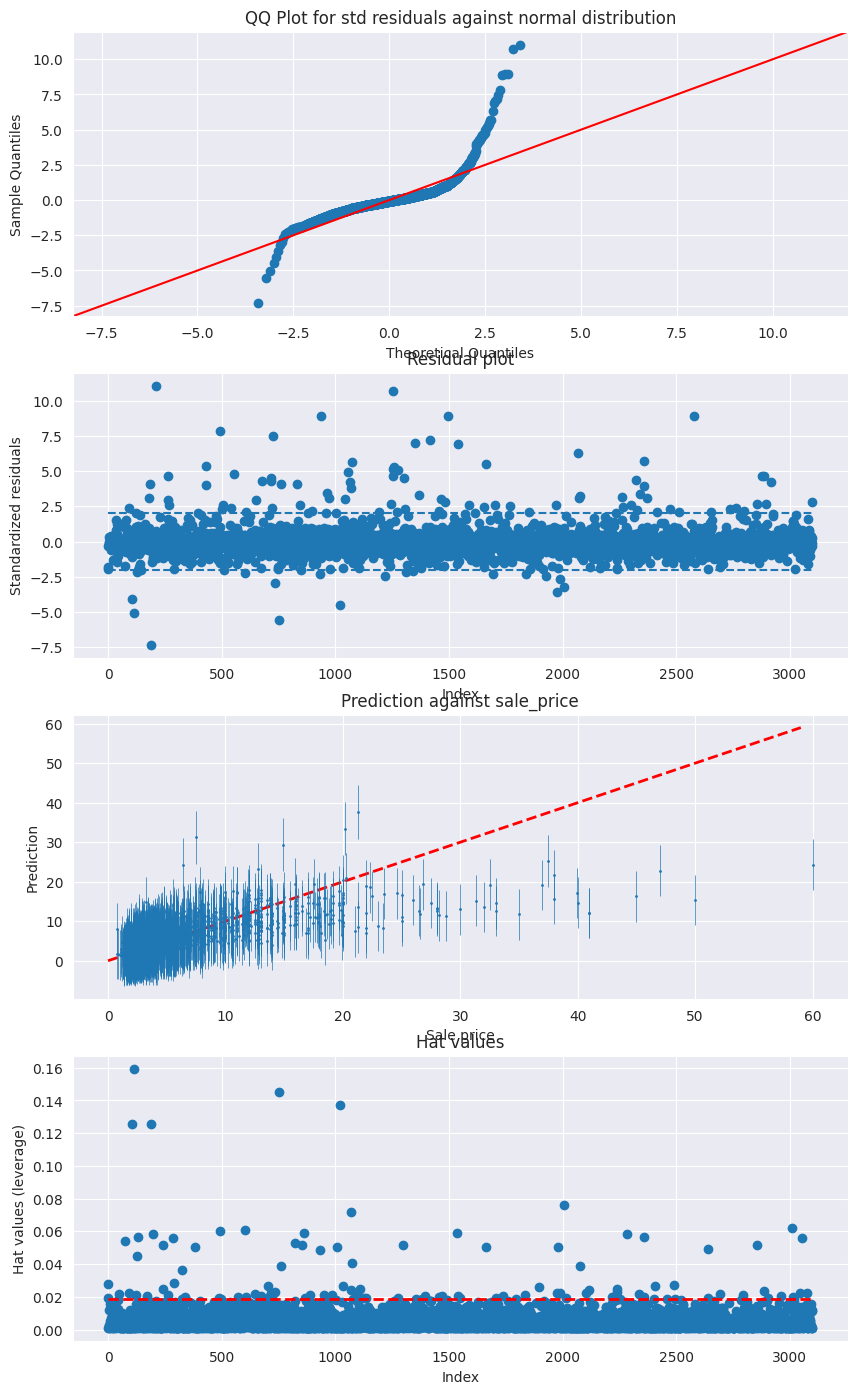

In [12]:
from statsmodels.graphics.gofplots import ProbPlot

std_residuals = fitted_ols.resid_pearson
pp = ProbPlot(std_residuals)
fig, axes = plt.subplots(4, 1, figsize = (10,17))
axes[0].set_title("QQ Plot for std residuals against normal distribution")
qq  = pp.qqplot(ax = axes[0], line="45")

axes[1].set_title("Residual plot")
axes[1].scatter(list(range(len(std_residuals))), std_residuals)
axes[1].hlines(y=[-2, 2], linestyles="dashed", xmin=0, xmax=len(std_residuals))
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Standardized residuals")

axes[2].set_title("Prediction against sale_price")
pred_summary = fitted_ols.get_prediction().summary_frame()
errors = np.array(list(zip(pred_summary["mean"] - pred_summary["obs_ci_lower"], abs(pred_summary["mean"] - pred_summary["obs_ci_upper"])))).T
axes[2].plot(np.arange(0, 60, 1), np.arange(0, 60, 1), linestyle = "dashed", color = "red", linewidth = 2)
axes[2].errorbar(train["sale_price"], pred_summary["mean"], yerr = errors, fmt = "o", markersize=1, linewidth = 0.5)
axes[2].set_xlabel("Sale price")
axes[2].set_ylabel("Prediction")

hat = fitted_ols.get_influence().hat_matrix_diag
reference = 3 * len(fitted_ols.params) / len(train["sale_price"])
axes[3].set_title("Hat values")
axes[3].scatter(list(range(len(hat))), hat)
axes[3].hlines(y=reference, linestyles="dashed", xmin=0, xmax=len(hat), color = "red", linewidth = 2)
axes[3].set_xlabel("Index")
axes[3].set_ylabel("Hat values (leverage)")





Conclusions:
- Right asymmetrical and overdispersed residuals (indicates a gamma or lognormal model may fit better to data)
- Large portion of residuals falls inside 2 stddev
- Considerable number of outliers with poor predictions
- Mean response seems to affect disperson (bonus points to gamma regression)
- Few points with high leverage, indicates that the model probably isnt broken from them

## Asymmetrical residual models

Gamma/inverse gaussian (I wrote log-normal in some places, mixed them up, sry Cibele) generalized linear models can capture asymmetry and overdispersion in data. Pointwise predictions are not affected, but error bars and confidence intervals can better reflect the data.

In [13]:
import statsmodels.genmod.families.family as family
import statsmodels.genmod.families.links as links

idgamma_model = smf.glm(
    formula = "sale_price ~ bedrooms + bathrooms + parking_spaces + area_total + C(property_type) + condominium_fee + has_pool + has_bbq + has_playground +has_sauna + has_party_room + has_sports_court + has_24h_security + has_laundry + has_closet + has_office + has_pantry + amenity_score",
    data = train,
    family = family.Gamma(link=links.Identity())
).fit()
idgamma_model.save("models/gamma_identity.pickle")
idgamma_model.summary()


/home/felipe/Documents/Usp/2025_2/IA/IA2025.2/Trabalho2/.venv/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             sale_price   No. Observations:                 3100
Model:                            GLM   Df Residuals:                     3082
Model Family:                   Gamma   Df Model:                           17
Link Function:               Identity   Scale:                         0.16336
Method:                          IRLS   Log-Likelihood:                -5939.8
Date:                Mon, 24 Nov 2025   Deviance:                       447.97
Time:                        21:29:43   Pearson chi2:                     503.
No. Iterations:                   100   Pseudo R-squ. (CS):             0.8622
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.2412      0.117     44.867      0.000       5.012       5.470
C(property_type)[T.Casa]    -0.9424      0.087    -10.872      0.000      -1.112      -0.772
has_pool[T.True]             0.7794      0.176      4.440      0.000       0.435       1.123
has_bbq[T.True]              0.2568      0.129      1.983      0.047       0.003       0.511
has_playground[T.True]       0.1184      0.155      0.765      0.444      -0.185       0.422
has_sauna[T.True]            1.5016      0.649      2.313      0.021       0.229       2.774
has_party_room[T.True]       0.3117      0.152      2.050      0.040       0.014       0.610
has_sports_court[T.True]     1.2381      0.244      5.065      0.000       0.759       1.717
has_24h_security[T.True]    -0.8798      0.130     -6.753      0.000      -1.135      -0.624
has_laundry[T.True]          0.0321      0.089      0.360      0.719      -0.143       0.207
has_closet[T.True]           1.3829      0.190      7.282      0.000       1.011       1.755
has_office[T.True]           0.6471      0.196      3.300      0.001       0.263       1.031
has_pantry[T.True]           0.3357      0.113      2.968      0.003       0.114       0.557
bedrooms                     0.5843      0.038     15.240      0.000       0.509       0.659
bathrooms                    0.1721      0.043      3.961      0.000       0.087       0.257
parking_spaces               0.5089      0.052      9.779      0.000       0.407       0.611
area_total                   1.7895      0.074     24.282      0.000       1.645       1.934
condominium_fee              0.4857      0.044     11.082      0.000       0.400       0.572
amenity_score               -0.0090      0.112     -0.081      0.936      -0.229       0.211
============================================================================================
"""

In [14]:
performance_metrics(idgamma_model)

PREDICTIVE RESULTS FOR TRAIN DATA
RMSE: 3.749472216687375
MAE: 1.7802353300278912
R2: 0.11167060991088595
PREDICTIVE RESULTS FOR TEST DATA
RMSE: 4.216875862904789
MAE: 1.9159778542320807
R2: -0.07255641741602004


Text(0, 0.5, 'Hat values (leverage)')

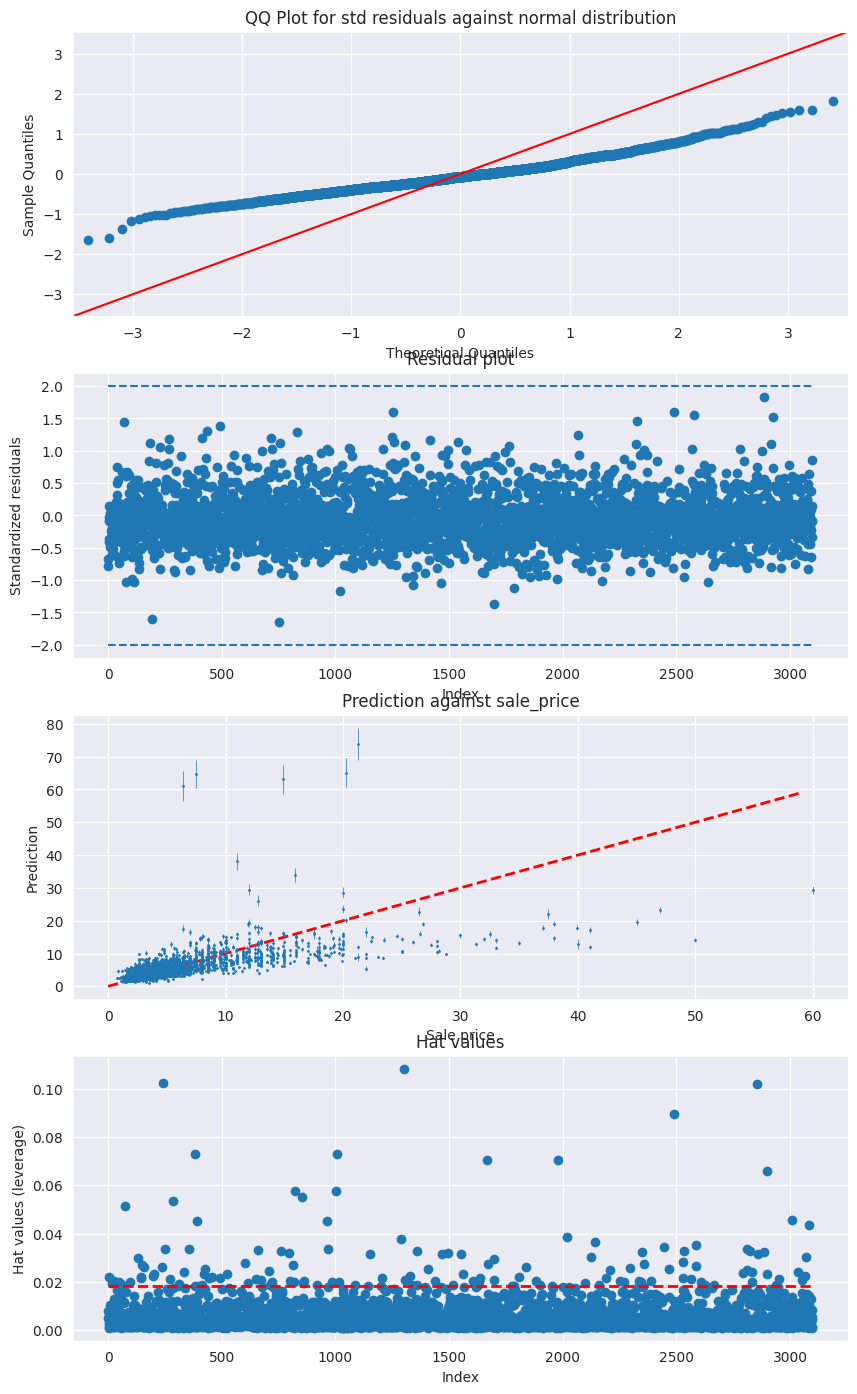

In [17]:
def get_gamma_prediction_interval(model, X_new, alpha=0.05, n_simulations=10000):
    """
    Generate prediction intervals for Gamma GLM using simulation.
    """
    # Get fitted values and parameters
    print(X_new)
    prediction = model.get_prediction(X_new)
    pred_summary = prediction.summary_frame(alpha=alpha)
    mu = pred_summary['mean'].values[0]

    # Get the scale parameter (phi) from the model
    scale = model.scale

    # For Gamma distribution: shape = mu^2 / variance, scale = variance / mu
    # In GLM: variance = phi * mu^2
    shape = mu / scale
    scale_param = scale

    # Simulate predictions
    simulated = np.random.gamma(shape, scale_param, n_simulations)

    # Calculate percentiles
    lower = np.percentile(simulated, 100 * alpha / 2)
    upper = np.percentile(simulated, 100 * (1 - alpha / 2))

    return {
        'mean': mu,
        'mean_ci_lower': pred_summary['mean_ci_lower'].values[0],
        'mean_ci_upper': pred_summary['mean_ci_upper'].values[0],
        'obs_ci_lower': lower,
        'obs_ci_upper': upper
    }


std_residuals = idgamma_model.resid_deviance # Deviance component residual is closest to normality
pp = ProbPlot(std_residuals, ss.norm(0, 1))
fig, axes = plt.subplots(4, 1, figsize = (10,17))
axes[0].set_title("QQ Plot for std residuals against normal distribution")
qq  = pp.qqplot(ax = axes[0], line="45")

axes[1].set_title("Residual plot")
axes[1].scatter(list(range(len(std_residuals))), std_residuals)
axes[1].hlines(y=[-2, 2], linestyles="dashed", xmin=0, xmax=len(std_residuals))
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Standardized residuals")

axes[2].set_title("Prediction against sale_price")
pred_summary = idgamma_model.get_prediction().summary_frame()
errors = np.array(list(zip(pred_summary["mean"] - pred_summary["mean_ci_lower"], abs(pred_summary["mean"] - pred_summary["mean_ci_upper"])))).T
axes[2].plot(np.arange(0, 60, 1), np.arange(0, 60, 1), linestyle = "dashed", color = "red", linewidth = 2)
axes[2].errorbar(train["sale_price"], pred_summary["mean"], yerr = errors, fmt = "o", markersize=1, linewidth = 0.5)
axes[2].set_xlabel("Sale price")
axes[2].set_ylabel("Prediction")

hat = idgamma_model.get_hat_matrix_diag(False)
reference = 3 * len(idgamma_model.params) / len(train["sale_price"])
axes[3].set_title("Hat values")
axes[3].scatter(list(range(len(hat))), hat)
axes[3].hlines(y=reference, linestyles="dashed", xmin=0, xmax=len(hat), color = "red", linewidth = 2)
axes[3].set_xlabel("Index")
axes[3].set_ylabel("Hat values (leverage)")

In [12]:
loggamma_model = smf.glm(
    formula = "sale_price ~ bedrooms + bathrooms + parking_spaces + area_total + C(property_type) + condominium_fee + has_pool + has_bbq + has_playground +has_sauna + has_party_room + has_sports_court + has_24h_security + has_laundry + has_closet + has_office + has_pantry + amenity_score",
    data = train,
    family = family.Gamma(link=links.Log())
).fit()

loggamma_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             sale_price   No. Observations:                 3100
Model:                            GLM   Df Residuals:                     3082
Model Family:                   Gamma   Df Model:                           17
Link Function:                    Log   Scale:                         0.17121
Method:                          IRLS   Log-Likelihood:                -6051.1
Date:                Sun, 23 Nov 2025   Deviance:                       482.01
Time:                        12:25:41   Pearson chi2:                     528.
No. Iterations:                   100   Pseudo R-squ. (CS):             0.8391
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    1.3009      0.030     43.793      0.000       1.243       1.359
C(property_type)[T.Casa]     0.0524      0.022      2.348      0.019       0.009       0.096
has_pool[T.True]             0.1228      0.036      3.412      0.001       0.052       0.193
has_bbq[T.True]             -0.0033      0.032     -0.102      0.918      -0.066       0.060
has_playground[T.True]      -0.0091      0.040     -0.225      0.822      -0.088       0.070
has_sauna[T.True]            0.1186      0.082      1.447      0.148      -0.042       0.279
has_party_room[T.True]       0.0238      0.036      0.657      0.511      -0.047       0.095
has_sports_court[T.True]     0.1297      0.044      2.966      0.003       0.044       0.215
has_24h_security[T.True]    -0.2663      0.033     -8.031      0.000      -0.331      -0.201
has_laundry[T.True]          0.0015      0.028      0.055      0.956      -0.053       0.056
has_closet[T.True]           0.1988      0.028      7.092      0.000       0.144       0.254
has_office[T.True]           0.1373      0.029      4.731      0.000       0.080       0.194
has_pantry[T.True]           0.1035      0.022      4.654      0.000       0.060       0.147
bedrooms                     0.1629      0.007     23.561      0.000       0.149       0.176
bathrooms                    0.0179      0.005      3.697      0.000       0.008       0.027
parking_spaces               0.0550      0.004     14.975      0.000       0.048       0.062
area_total                   0.1256      0.005     25.114      0.000       0.116       0.135
condominium_fee              0.1208      0.009     14.107      0.000       0.104       0.138
amenity_score                0.0162      0.004      4.041      0.000       0.008       0.024
============================================================================================
"""

In [13]:
performance_metrics(loggamma_model)

PREDICTIVE RESULTS FOR TRAIN DATA
RMSE: 29.05724710684007
MAE: 2.774249017459534
R2: 0.036649275373217716
PREDICTIVE RESULTS FOR TEST DATA
RMSE: 178.1118489618965
MAE: 8.307831963414367
R2: 0.0054063944420637


Text(0, 0.5, 'Hat values (leverage)')

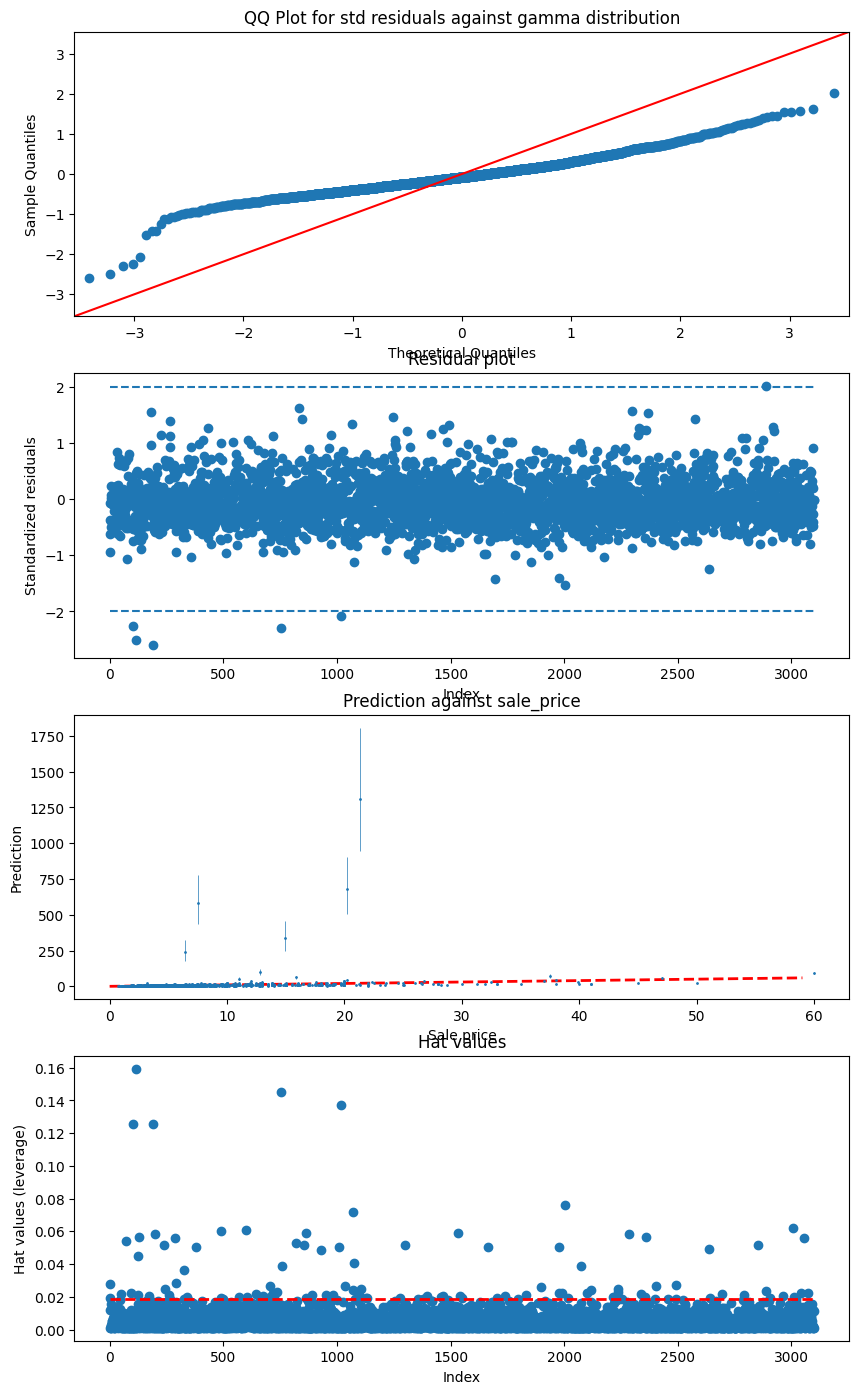

In [14]:
std_residuals = loggamma_model.resid_deviance # Deviance component residual is closest to normality
pp = ProbPlot(std_residuals, ss.norm(0, 1))
fig, axes = plt.subplots(4, 1, figsize = (10,17))
axes[0].set_title("QQ Plot for std residuals against normal distribution")
qq  = pp.qqplot(ax = axes[0], line="45")

axes[1].set_title("Residual plot")
axes[1].scatter(list(range(len(std_residuals))), std_residuals)
axes[1].hlines(y=[-2, 2], linestyles="dashed", xmin=0, xmax=len(std_residuals))
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Standardized residuals")

axes[2].set_title("Prediction against sale_price")
pred_summary = loggamma_model.get_prediction().summary_frame()
errors = np.array(list(zip(pred_summary["mean"] - pred_summary["obs_ci_lower"], abs(pred_summary["mean"] - pred_summary["obs_ci_upper"])))).T
axes[2].plot(np.arange(0, 60, 1), np.arange(0, 60, 1), linestyle = "dashed", color = "red", linewidth = 2)
axes[2].errorbar(train["sale_price"], pred_summary["mean"], yerr = errors, fmt = "o", markersize=1, linewidth = 0.5)
axes[2].set_xlabel("Sale price")
axes[2].set_ylabel("Prediction")

hat = loggamma_model.get_hat_matrix_diag(False)
reference = 3 * len(idgamma_model.params) / len(train["sale_price"])
axes[3].set_title("Hat values")
axes[3].scatter(list(range(len(hat))), hat)
axes[3].hlines(y=reference, linestyles="dashed", xmin=0, xmax=len(hat), color = "red", linewidth = 2)
axes[3].set_xlabel("Index")
axes[3].set_ylabel("Hat values (leverage)")

In [15]:
invgamma_model = smf.glm(
    formula = "sale_price ~ bedrooms + bathrooms + parking_spaces + area_total + C(property_type) + condominium_fee + has_pool + has_bbq + has_playground +has_sauna + has_party_room + has_sports_court + has_24h_security + has_laundry + has_closet + has_office + has_pantry + amenity_score",
    data = train,
    family = family.Gamma(link=links.InversePower())
).fit()

invgamma_model.summary()

/home/felipe/Documents/Usp/2025_2/IA/IA2025.2/Trabalho2/.venv/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             sale_price   No. Observations:                 3100
Model:                            GLM   Df Residuals:                     3082
Model Family:                   Gamma   Df Model:                           17
Link Function:           InversePower   Scale:                         0.33981
Method:                          IRLS   Log-Likelihood:                -9437.4
Date:                Sun, 23 Nov 2025   Deviance:                       2415.0
Time:                        12:25:42   Pearson chi2:                 1.05e+03
No. Iterations:                    12   Pseudo R-squ. (CS):             -1.722
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.2748      0.006     44.704      0.000       0.263       0.287
C(property_type)[T.Casa]    -0.0298      0.005     -6.589      0.000      -0.039      -0.021
has_pool[T.True]            -0.0228      0.004     -6.106      0.000      -0.030      -0.016
has_bbq[T.True]              0.0074      0.004      1.787      0.074      -0.001       0.016
has_playground[T.True]       0.0046      0.005      0.883      0.377      -0.006       0.015
has_sauna[T.True]           -0.0018      0.006     -0.296      0.767      -0.013       0.010
has_party_room[T.True]      -0.0037      0.005     -0.741      0.459      -0.014       0.006
has_sports_court[T.True]     0.0065      0.004      1.534      0.125      -0.002       0.015
has_24h_security[T.True]     0.0324      0.004      7.940      0.000       0.024       0.040
has_laundry[T.True]          0.0128      0.005      2.745      0.006       0.004       0.022
has_closet[T.True]          -0.0270      0.003    -10.654      0.000      -0.032      -0.022
has_office[T.True]          -0.0263      0.002    -15.347      0.000      -0.030      -0.023
has_pantry[T.True]          -0.0207      0.003     -7.922      0.000      -0.026      -0.016
bedrooms                    -0.0275      0.000    -64.603      0.000      -0.028      -0.027
bathrooms                   -0.0027      0.000    -10.793      0.000      -0.003      -0.002
parking_spaces              -0.0091      0.000    -35.700      0.000      -0.010      -0.009
area_total                  -0.0072      0.000    -61.036      0.000      -0.007      -0.007
condominium_fee             -0.0161      0.001    -29.637      0.000      -0.017      -0.015
amenity_score               -0.0038      0.000    -12.517      0.000      -0.004      -0.003
============================================================================================
"""

In [16]:
performance_metrics(invgamma_model)

PREDICTIVE RESULTS FOR TRAIN DATA
RMSE: 17.954787879241007
MAE: 3.3418529091537423
R2: 0.013301945245659086
PREDICTIVE RESULTS FOR TEST DATA
RMSE: 141.30736488177416
MAE: 7.8340426103613865
R2: 0.008118685717819152


/home/felipe/Documents/Usp/2025_2/IA/IA2025.2/Trabalho2/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:325: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)


Text(0, 0.5, 'Hat values (leverage)')

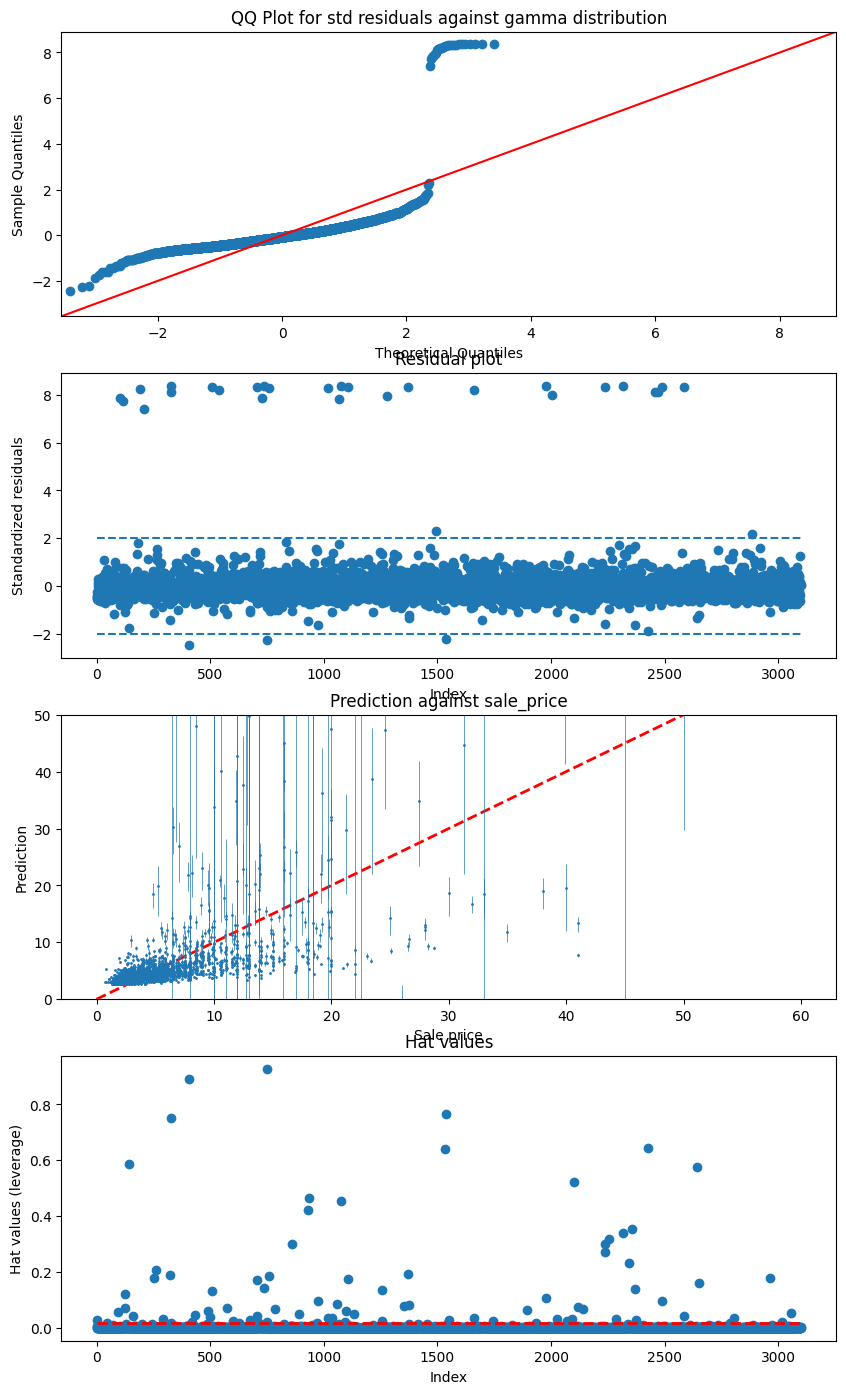

In [17]:
std_residuals = invgamma_model.resid_deviance # Deviance component residual is closest to normality
pp = ProbPlot(std_residuals, ss.norm(0, 1))
fig, axes = plt.subplots(4, 1, figsize = (10,17))
axes[0].set_title("QQ Plot for std residuals against normal distribution")
qq  = pp.qqplot(ax = axes[0], line="45")

axes[1].set_title("Residual plot")
axes[1].scatter(list(range(len(std_residuals))), std_residuals)
axes[1].hlines(y=[-2, 2], linestyles="dashed", xmin=0, xmax=len(std_residuals))
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Standardized residuals")

axes[2].set_title("Prediction against sale_price")
pred_summary = invgamma_model.get_prediction().summary_frame()
errors = np.array(list(zip(abs(pred_summary["mean"] - pred_summary["obs_ci_lower"]), abs(pred_summary["mean"] - pred_summary["obs_ci_upper"])))).T
axes[2].plot(np.arange(0, 60, 1), np.arange(0, 60, 1), linestyle = "dashed", color = "red", linewidth = 2)
axes[2].errorbar(train["sale_price"], pred_summary["mean"], yerr = errors, fmt = "o", markersize=1, linewidth = 0.5)
axes[2].set_xlabel("Sale price")
axes[2].set_ylabel("Prediction")
axes[2].set(ylim=(0, 50))

hat = invgamma_model.get_hat_matrix_diag(False)
reference = 3 * len(idgamma_model.params) / len(train["sale_price"])
axes[3].set_title("Hat values")
axes[3].scatter(list(range(len(hat))), hat)
axes[3].hlines(y=reference, linestyles="dashed", xmin=0, xmax=len(hat), color = "red", linewidth = 2)
axes[3].set_xlabel("Index")
axes[3].set_ylabel("Hat values (leverage)")

Conclusions on gamma model: underdispersed residuals indicate that the model is too conservative, with big error bars. Inverse and log link function have poor predictive capability and worse inferential metrics, so we stick to the identity. Gamma regression achieves a smaller MAE, but bigger RMSE. Additionaly, QQ plots show that gamma regression captures the asymmetry, but overestimates confidence intervals.

Building an INverse Normal model is futile, since its supposed to capture overdispersion in gamma regression.

## XGBoost

For a less inference focused model/ prediction focused model, we will use bossted trees with the XGBoost model

In [18]:
# Just tidying the data format, returns X, Y
def convert_to_xbg(df : pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    df = df.drop(columns="property_code")

    Y = df["sale_price"]
    # Numerical variables (unaltered)
    num = df.select_dtypes(include = "number").drop(columns=["sale_price", "exp(area_util)", "exp(area_total)"])
    boolean = df.select_dtypes(include = "boolean")
    cat = df.select_dtypes(include = "object").astype("category")
    X = pd.concat([num, boolean, cat], axis = 1)
    return X, Y

Xtrain, Ytrain = convert_to_xbg(train)
Xtest, Ytest = convert_to_xbg(test)


In [19]:
Xtrain

,bedrooms,bathrooms,parking_spaces,area_util,area_total,condominium_fee,amenity_score,has_pool,has_bbq,has_playground,...,has_party_room,has_sports_court,has_24h_security,has_laundry,has_closet,has_office,has_pantry,property_type,property_subtype,size_category
1063,-0.653203,-0.458498,6.610786,-0.367949,1.469928,-0.590014,-0.467044,False,False,False,...,False,False,False,False,False,False,False,Casa,Padrão,medium
1809,-0.653203,3.097050,3.337302,1.182452,11.922535,-0.590014,0.266153,True,False,False,...,False,False,False,True,True,False,False,Casa,Casa de Condomínio,extra_large
270,-0.653203,-0.458498,-0.754552,-0.819721,-0.879934,0.847826,-0.467044,False,False,False,...,False,False,False,True,False,False,False,Apartamento,Padrão,medium
2011,-0.653203,-0.458498,-0.754552,-0.901862,-0.853605,-0.590014,2.465744,True,True,True,...,False,False,True,True,False,False,False,Apartamento,Padrão,small
3723,0.642137,-0.458498,-0.754552,-0.768384,-0.847023,-0.590014,-0.467044,False,False,False,...,False,False,False,True,False,False,False,Apartamento,Padrão,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,-1.948542,-0.458498,-0.754552,-0.973735,-0.978668,0.145245,-0.467044,False,False,False,...,False,False,False,True,False,False,False,Apartamento,Flat,small
3526,1.937477,4.874824,0.882190,1.182452,0.403604,-0.590014,-0.467044,False,False,False,...,False,False,False,True,False,False,True,Apartamento,Padrão,extra_large
1739,-0.653203,-0.458498,-0.754552,-0.758116,-0.840441,0.815147,-0.467044,False,False,False,...,False,False,False,True,False,False,False,Apartamento,Padrão,medium
822,0.642137,-0.458498,0.063819,-0.100993,0.403604,-0.590014,-0.467044,False,False,False,...,False,False,False,True,False,False,False,Casa,Padrão,large


In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from pprint import pprint


base_params = {
    'device': 'cpu', # GPU is hard to configure
    'tree_method': 'hist',
    'enable_categorical': True,
    'random_state': seed,
    'n_jobs': 1,
    'verbosity': 1
}

param_dist = {
    'n_estimators': randint(50, 350),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.001, 0.2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 10),
    'min_child_weight': randint(1, 10),
    'reg_lambda': uniform(0, 5),  # L2 regularization
    'reg_alpha': uniform(0, 2)  # L1 regularization
}

xgb_model = XGBRegressor(**base_params)
random_search = RandomizedSearchCV(
    xgb_model,
    param_dist,
    n_iter=30000,  # Number of parameter combinations to sample
    cv=4,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=seed
)
random_search.fit(Xtrain, Ytrain)
best_params = random_search.best_params_
best_model = random_search.best_estimator_
pprint(best_params)
# Save the best model to JSON (preserves categorical values)
best_model.save_model('xgb_model.json')

Fitting 4 folds for each of 30000 candidates, totalling 120000 fits
{'colsample_bytree': np.float64(0.7763996707758167),
 'gamma': np.float64(7.675048209679184),
 'learning_rate': np.float64(0.03091358701886393),
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 179,
 'reg_alpha': np.float64(1.330444736610654),
 'reg_lambda': np.float64(0.16189071367822605),
 'subsample': np.float64(0.5275494646072035)}


In [22]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.load_model("models/xgb_model.json")
xgb_model

,objective,'reg:squarederror'
,base_score,[5.3722706]
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [23]:
predicted = xgb_model.predict(Xtest)
xgb_rmse = root_mean_squared_error(Ytest, predicted)
xgb_mae = mean_absolute_error(Ytest, predicted)
xgb_r2_score = r2_score(Ytest, predicted)

print("PREDICTIVE METRICS FOR XGBOOST MODEL")
print(f"RMSE: {xgb_rmse}")
print(f"MAE: {xgb_mae}")
print(f"R^2: {xgb_r2_score}")

PREDICTIVE METRICS FOR XGBOOST MODEL
RMSE: 3.28680055581466
MAE: 1.6243250928333128
R^2: 0.5729351857681739


[(0.0, 50.0)]

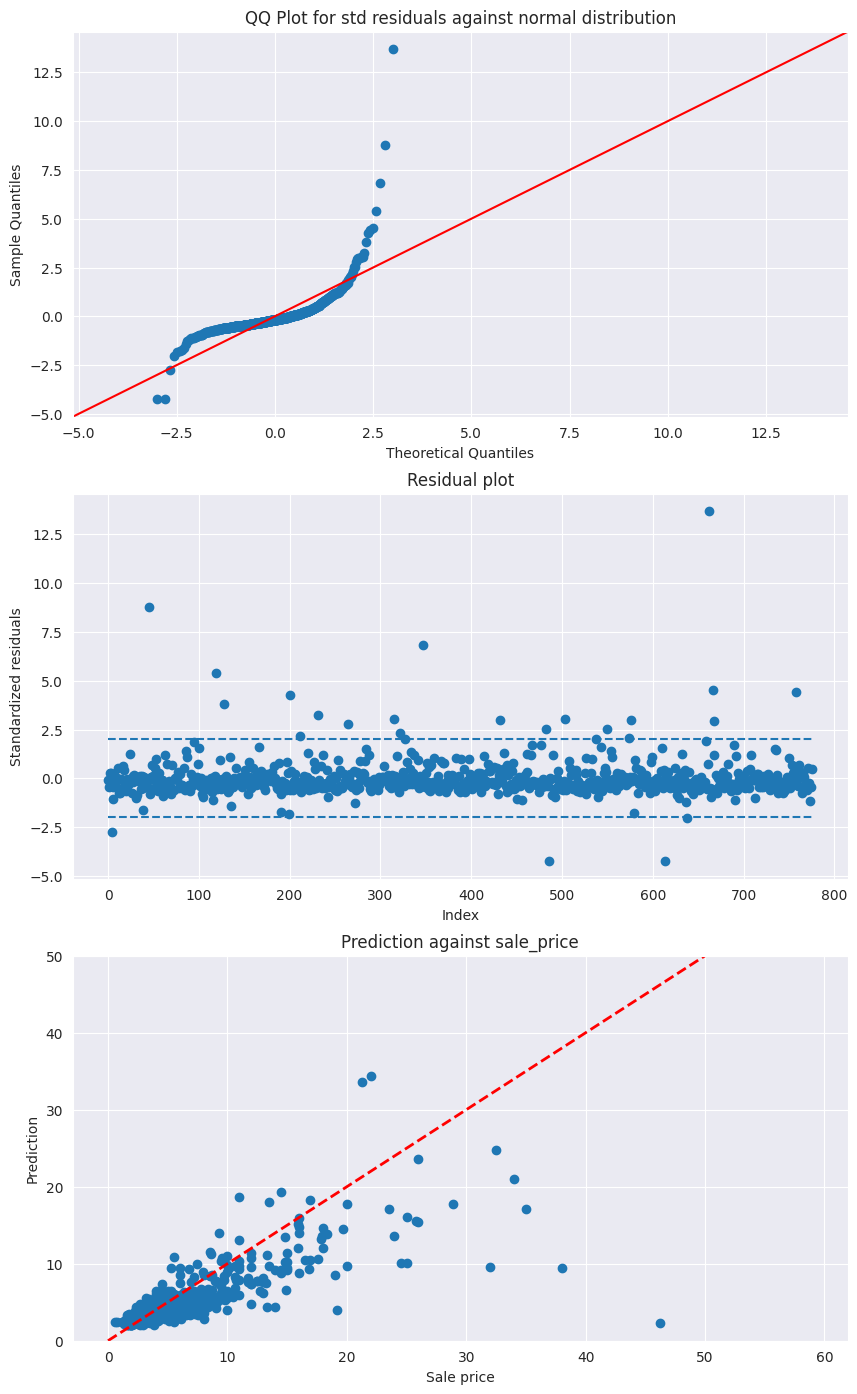

In [24]:
from statsmodels.graphics.gofplots import ProbPlot
residuals = (Ytest - predicted).to_numpy()
std_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

pp = ProbPlot(std_residuals, ss.norm(0, 1))
fig, axes = plt.subplots(3, 1, figsize = (10,17))
axes[0].set_title("QQ Plot for std residuals against normal distribution")
qq  = pp.qqplot(ax = axes[0], line="45")

axes[1].set_title("Residual plot")
axes[1].scatter(list(range(len(std_residuals))), std_residuals)
axes[1].hlines(y=[-2, 2], linestyles="dashed", xmin=0, xmax=len(std_residuals))
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Standardized residuals")

axes[2].set_title("Prediction against sale_price")
plt.scatter(Ytest.to_numpy(), predicted)
axes[2].plot(np.arange(0, 60, 1), np.arange(0, 60, 1), linestyle = "dashed", color = "red", linewidth = 2)
axes[2].set_xlabel("Sale price")
axes[2].set_ylabel("Prediction")
axes[2].set(ylim=(0, 50))


In [3]:
rent_data = pd.read_csv("data/clean_data_rent.csv")
rent_data

,property_code,property_type,property_subtype,rent_price,bedrooms,bathrooms,parking_spaces,area_util,area_total,condominium_fee,...,has_sauna,has_party_room,has_sports_court,has_24h_security,has_laundry,has_closet,has_office,has_pantry,size_category,amenity_score
0,84989-L,Casa,Casa de Condomínio,7400.0,3,1,2,200.0,350.0,600.0,...,False,False,False,False,True,True,False,False,extra_large,1
1,84988-L,Casa,Casa de Condomínio,7400.0,3,1,2,200.0,350.0,600.0,...,False,False,False,False,True,True,False,False,extra_large,1
2,84986-L,Apartamento,Padrão,830.0,2,1,1,50.0,50.0,300.0,...,False,False,False,False,True,False,False,False,medium,0
3,84972-L,Casa,Padrão,1667.0,2,1,3,70.0,250.0,0.0,...,False,False,False,False,True,False,False,False,medium,1
4,84953-L,Casa,Padrão,2400.0,3,1,1,118.0,207.0,0.0,...,False,False,False,False,True,True,False,False,large,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,2759-L,Casa,Padrão,8889.0,3,1,4,460.0,990.0,0.0,...,False,False,False,False,True,False,False,False,extra_large,0
741,1381-L,Casa,Sobrado,8334.0,4,2,3,420.0,420.0,0.0,...,False,False,False,False,True,False,False,False,extra_large,0
742,1354-L,Casa,Casa de Condomínio,8200.0,4,1,4,282.0,476.0,571.0,...,False,False,False,False,False,False,False,True,extra_large,0
743,894-L,Apartamento,Padrão,2500.0,2,2,1,62.0,62.0,480.0,...,False,False,False,False,True,False,False,False,medium,0


In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(rent_data, test_size = 0.2)

# Just tidying the data format, returns X, Y
def convert_to_xbg(df : pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    df = df.drop(columns="property_code")

    Y = df["rent_price"]
    # Numerical variables (unaltered)
    num = df.select_dtypes(include = "number").drop(columns=["rent_price", "amenity_score"])
    boolean = df.select_dtypes(include = "boolean")
    cat = df.select_dtypes(include = "object").drop(columns=["property_subtype", "size_category"]).astype("category")
    X = pd.concat([num, boolean, cat], axis = 1)
    return X, Y

Xtrain, Ytrain = convert_to_xbg(train)
Xtest, Ytest = convert_to_xbg(test)
Xtrain

,bedrooms,bathrooms,parking_spaces,area_util,area_total,condominium_fee,has_pool,has_bbq,has_playground,has_sauna,has_party_room,has_sports_court,has_24h_security,has_laundry,has_closet,has_office,has_pantry,property_type
331,2,2,2,170.0,150.0,0.0,False,False,False,False,False,False,False,True,False,False,False,Casa
74,2,1,1,50.0,50.0,277.0,False,True,True,False,False,False,True,True,False,False,False,Apartamento
196,3,1,2,300.0,300.0,0.0,False,False,False,False,False,False,False,True,False,False,False,Casa
29,2,1,1,51.0,51.0,370.0,False,False,False,False,False,False,False,True,False,False,False,Apartamento
653,3,2,3,262.0,240.0,0.0,False,False,False,False,True,False,False,True,False,True,False,Casa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,3,1,4,145.0,254.0,0.0,False,False,False,False,False,False,False,True,False,False,True,Casa
15,3,1,1,70.0,70.0,500.0,False,False,False,False,False,False,True,True,False,False,False,Apartamento
121,3,1,2,389.0,507.0,0.0,True,True,False,False,False,False,False,True,False,True,False,Casa
420,3,1,2,109.0,109.0,600.0,True,True,False,False,False,False,False,True,False,False,False,Apartamento


In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from pprint import pprint

base_params = {
    'device': 'cpu', # GPU is hard to configure
    'tree_method': 'hist',
    'enable_categorical': True,
    'random_state': 124,
    'n_jobs': 1,
    'verbosity': 1
}

param_dist = {
    'n_estimators': randint(50, 350),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.001, 0.2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 10),
    'min_child_weight': randint(1, 10),
    'reg_lambda': uniform(0, 5),  # L2 regularization
    'reg_alpha': uniform(0, 2)  # L1 regularization
}

xgb_model_rent = XGBRegressor(**base_params)
random_search = RandomizedSearchCV(
    xgb_model_rent,
    param_dist,
    n_iter=10000,  # Number of parameter combinations to sample
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=123
)
random_search.fit(Xtrain, Ytrain)
best_params_rent = random_search.best_params_
best_model_rent = random_search.best_estimator_
pprint(best_params_rent)
# Save the best model to JSON (preserves categorical values)
best_model_rent.save_model('xgb_model_rent.json')

Fitting 3 folds for each of 10000 candidates, totalling 30000 fits
{'colsample_bytree': np.float64(0.6693052555378327),
 'gamma': np.float64(3.0799935520363486),
 'learning_rate': np.float64(0.03485363689000953),
 'max_depth': 12,
 'min_child_weight': 1,
 'n_estimators': 140,
 'reg_alpha': np.float64(0.6524073675088871),
 'reg_lambda': np.float64(3.8490940245272522),
 'subsample': np.float64(0.5217883827462502)}


In [16]:
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
xgb_model = XGBRegressor()
xgb_model.load_model("xgb_model_rent.json")
predicted = xgb_model.predict(Xtest)
xgb_rmse = root_mean_squared_error(Ytest, predicted)
xgb_mae = mean_absolute_error(Ytest, predicted)
xgb_r2_score = r2_score(Ytest, predicted)

print("PREDICTIVE METRICS FOR XGBOOST MODEL")
print(f"RMSE: {xgb_rmse}")
print(f"MAE: {xgb_mae}")
print(f"R^2: {xgb_r2_score}")

PREDICTIVE METRICS FOR XGBOOST MODEL
RMSE: 1717.4521291540543
MAE: 782.8928288197358
R^2: 0.5201103322429139
